# S-Wave Simulation

S-Wave or Secondary Wave or Shear Wave is the second seismic waves that arrived in the seismograph when earthquake happens. S-waves are transverse waves (direction of particle movement on S-wave is perpendicular to the direction of wave propagation). S-wave cannot traverse through liquids and gases. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

### Elastic Wave Equation
$$
\rho \frac{\partial^2 u_x}{\partial t^2} = \frac{\partial^2 \tau_{xy}}{\partial y} + S \\
\rho \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial^2 \tau_{xy}}{\partial x} +S
$$

Where:
- $\rho$ is the density
- $\tau_{xy}$ is the shear stress
- $u_x, u_y$ is the horizontal and vertical displacements
- $S$ is the vertical force or source term (Ricker Wavelet)

In [2]:
# Simulation Area Parameter
NX, NY = 200, 200  #Grid size
XMIN, XMAX = 0.0, 2000.0  
YMIN, YMAX = 0.0, 2000.0  

# Animation Plot Parameter
PLOT_EVERY = 5  

In [3]:
# For Laplacian Approximation using FDM
DX = (XMAX - XMIN) / NX  # Spatial step (m)
DT = 0.001  # Time step (s)
NT = 900  

#### Shear Modulus
Shear Modulus is used to measure how materials withstand deformation when a force is applied to the materials. The formula is
$$
\mu = \rho  v_s^2
$$

In [5]:
VS = np.ones((NX, NY)) * 1500.0  # shear wave velocity
RHO = np.ones((NX, NY)) * 2000.0  # Density
MU = RHO * VS**2  # Shear modulus 

# Two-layer model example:
# VS[NX//2:, :] = 2000.0  # Higher velocity layer
# RHO[NX//2:, :] = 2500.0  # Higher density layer
# MU = RHO * VS**2  # Recalculate shear modulus

In [6]:
ux = np.zeros((NX, NY))  # x-component of displacement
uy = np.zeros((NX, NY))  # y-component of displacement
ux_prev = np.zeros((NX, NY))  # Previous time step
uy_prev = np.zeros((NX, NY))  # Previous time step

In [7]:
# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

### Ricker Wavelet
Ricker wavelet is the second derivative of a Gaussian function. It can mimic real seismic source, so we can conduct our numerical simulation based on it. The standard formula in the time domain is

$$
    A(t) = \left( 1-2\pi^2 f_0^2 t^2 \right) e^{- \pi^2 f_0^2 t^2}
$$
where
- $f_0$ is the peak frequency in Hertz

In [8]:
# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_x, source_y = NX//4, NY//2  # Source position
source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=20.0) * 1e6  

#### Hooke Law 
Hooke Law is used for expressing the stress-strain relationship in the medium.
$$
\tau_{xy} = \mu \left( \frac{\partial u_y}{\partial x} + \frac{\partial u_x}{\partial y} \right)
$$

### Discretization
Now, based on Hooke's Law, we can compute the discretization of the partial derivatives using central differences FDM. 

$$
\frac{\partial u_x}{\partial y} \approx \frac{u_x^{i,j+1} - u_x^{i,j-1}}{2 \nabla y}
$$

Using leapfrog scheme, the time stepping is
$$
u_x^{t+1} = 2u_x^t - u_x^{t-1} + \frac{\Delta t^2}{\rho} \left( \frac{\tau_{xy}^{i,j+1} - \tau_{xy}^{i,j-1}}{2 \Delta y} + S \right)
$$


In [9]:
def update_wave(n):
    """Update the wave field for one time step for SV-waves"""
    global ux, uy, ux_prev, uy_prev
    
    # Add source (vertical force)
    if n < len(source_amp):
        uy[source_x, source_y] += source_amp[n] * DT**2 / RHO[source_x, source_y]
    
    # Calculate spatial derivatives
    dux_dx = np.zeros_like(ux)
    dux_dy = np.zeros_like(ux)
    duy_dx = np.zeros_like(uy)
    duy_dy = np.zeros_like(uy)
    
    # Central differences for derivatives
    dux_dx[1:-1, 1:-1] = (ux[2:, 1:-1] - ux[:-2, 1:-1]) / (2*DX)
    dux_dy[1:-1, 1:-1] = (ux[1:-1, 2:] - ux[1:-1, :-2]) / (2*DX)
    duy_dx[1:-1, 1:-1] = (uy[2:, 1:-1] - uy[:-2, 1:-1]) / (2*DX)
    duy_dy[1:-1, 1:-1] = (uy[1:-1, 2:] - uy[1:-1, :-2]) / (2*DX)
    
    tau_xy = MU * (duy_dx + dux_dy)
    
    ux_new = np.zeros_like(ux)
    uy_new = np.zeros_like(uy)
    
    # x-component
    ux_new[1:-1, 1:-1] = (
        2*ux[1:-1, 1:-1] - ux_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy[1:-1, 2:] - tau_xy[1:-1, :-2]) / (2*DX)  # ∂τ_xy/∂y
        )
    )
    
    # y-component
    uy_new[1:-1, 1:-1] = (
        2*uy[1:-1, 1:-1] - uy_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy[2:, 1:-1] - tau_xy[:-2, 1:-1]) / (2*DX)  # ∂τ_xy/∂x
        )
    )
    
    ux_new *= damping
    uy_new *= damping
    
    ux_prev = ux.copy()
    uy_prev = uy.copy()
    ux = ux_new.copy()
    uy = uy_new.copy()

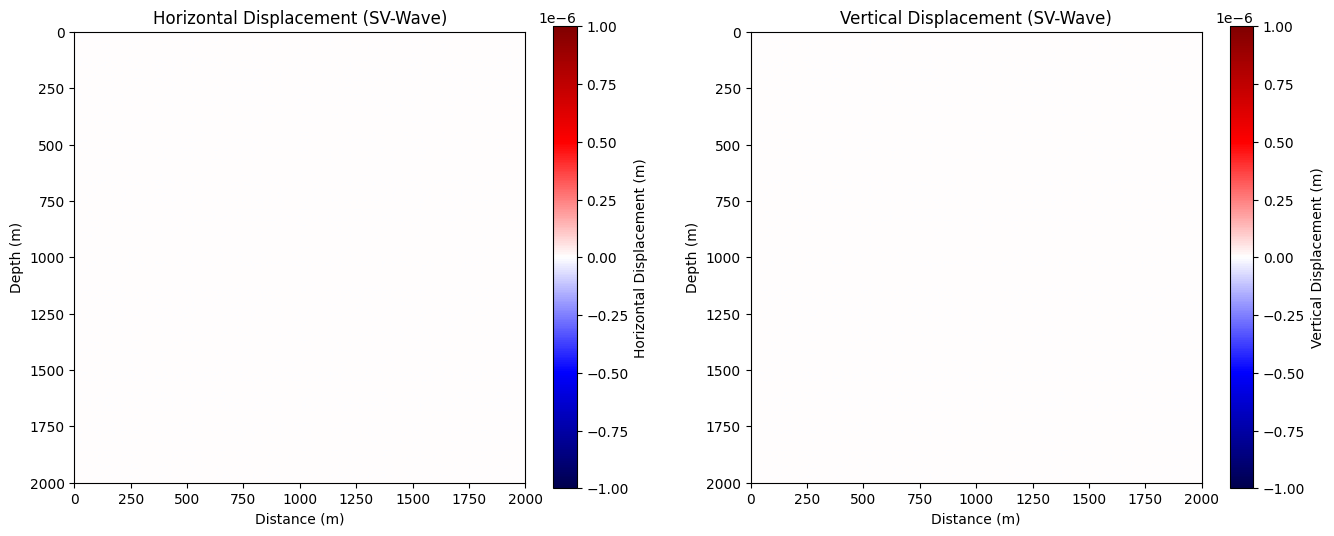

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal displacement plot
img1 = ax1.imshow(ux.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                 cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar(img1, ax=ax1, label='Horizontal Displacement (m)')
ax1.set_title("Horizontal Displacement (SV-Wave)")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

# Vertical displacement plot
img2 = ax2.imshow(uy.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                 cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar(img2, ax=ax2, label='Vertical Displacement (m)')
ax2.set_title("Vertical Displacement (SV-Wave)")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth (m)")

# depth_separator = (YMAX - YMIN) * (NX // 2) / NX
# for ax in [ax1, ax2]:
#     ax.axhline(depth_separator, color='black', linestyle='--', 
#               linewidth=1.5, label='Layer Boundary')
#     ax.legend()

plt.show()

In [12]:
def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_wave(frame * PLOT_EVERY + _)
    
    current_max = max(np.max(np.abs(ux)), np.max(np.abs(uy)))
    vlimit = current_max if current_max > 0 else 1e-6
    
    img1.set_array(ux.T)
    img1.set_clim(vmin=-vlimit, vmax=vlimit)
    
    img2.set_array(uy.T)
    img2.set_clim(vmin=-vlimit, vmax=vlimit)
    
    return [img1, img2]

In [13]:
ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, 
                   interval=50, blit=True)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('test_s_wave1.mp4', writer=ffmpeg_writer)